In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim, utils
from torchvision import models, datasets, transforms

import PIL.Image as Image

from tqdm import tqdm
import random
import cv2
import os
import time

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,10)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device ...", device)

Using device ... cuda


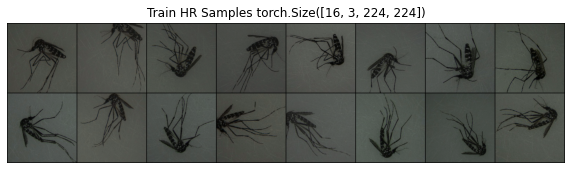

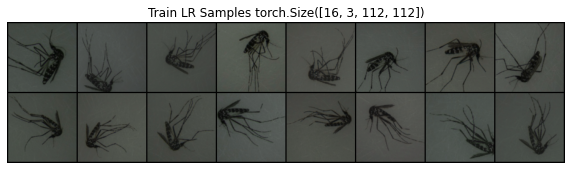

In [2]:
init_scale = 1.15

down_scale = 2

transforms_train_HR = transforms.Compose([
    transforms.ColorJitter(brightness=0.1,contrast=0.2,saturation=0.2,hue=0.1),
    transforms.RandomAffine(360,scale=[init_scale-0.15,init_scale+0.15]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

transforms_train_LR = transforms.Compose([
    transforms.ColorJitter(brightness=0.1,contrast=0.2,saturation=0.2,hue=0.1),
    transforms.RandomAffine(360,scale=[init_scale-0.15,init_scale+0.15]),
    transforms.CenterCrop(224),
    transforms.Resize(224//down_scale),
    transforms.ToTensor(),
])

transforms_test = transforms.Compose([
    transforms.Resize(224//down_scale),
    transforms.ToTensor()
])
    
train_dataset_HR = datasets.ImageFolder("/media/data/MosquitoDL/TrainVal/", transform=transforms_train_HR)
train_loader_HR = utils.data.DataLoader(train_dataset_HR, batch_size=16, shuffle=False)

train_dataset_LR = datasets.ImageFolder("/media/data/MosquitoDL/TrainVal/", transform=transforms_train_LR)
train_loader_LR = utils.data.DataLoader(train_dataset_LR, batch_size=16, shuffle=False)

test_dataset = datasets.ImageFolder("/media/data/MosquitoDL/Test/", transform=transforms_test)
test_loader = utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

# Show samples
batch_sample_HR = next(iter(train_loader_HR))
image_samples_HR = torchvision.utils.make_grid(batch_sample_HR[0],nrow=8).permute((1,2,0))

# Show samples
batch_sample_LR = next(iter(train_loader_LR))
image_samples_LR = torchvision.utils.make_grid(batch_sample_LR[0],nrow=8).permute((1,2,0))

fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(image_samples_HR)
ax.set_title(f"Train HR Samples {batch_sample_HR[0].shape}")
plt.savefig("./batch_samples.jpg")

fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(image_samples_LR)
ax.set_title(f"Train LR Samples {batch_sample_LR[0].shape}")
plt.savefig("./batch_samples.jpg")

In [3]:
def get_model(model, pretrained=False, num_classes = 6):
    if model == 'resnet152':
        net = models.resnet152(pretrained=pretrained)
        net.fc = nn.Linear(in_features=2048, out_features=num_classes)
    elif model == 'resnet18':
        net = models.resnet18(pretrained=pretrained)
        net.fc = nn.Linear(in_features=512, out_features=num_classes)
    return net
teacher_name = 'resnet152'
student_name = 'resnet18'
print(f"Teacher: {teacher_name}, Student: {student_name}")

net_t = get_model(teacher_name, pretrained=False, num_classes=6)
net_t = net_t.to(device)
teacher_dict = torch.load("./models/original/best_resnet152_x1_True.pth")
print(f"Distillate teacher's HR(x1) knowledge with accuracy {teacher_dict['acc']*100:.2f}%")
net_t.load_state_dict(teacher_dict['net'])

net_s = get_model(student_name, pretrained=False, num_classes=6)
net_s = net_t.to(device)

Teacher: resnet152, Student: resnet18
Distillate teacher's HR(x1) knowledge with accuracy 95.98%


In [4]:
def loss_fn_kd(outputs, labels, teacher_outputs, params):
    """
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha
    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! See Issue #2
    """
    alpha = params.alpha
    T = params.temperature
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)

    return KD_loss

In [5]:
class KD_loss():
    def __init__(self, params):
        self.fn = nn.KLDivLoss()
        self.alpha = params['alpha']
        self.T = params['T']
    def __call__(self, student_outputs, teacher_outputs):
        return self.fn(F.log_softmax(student_outputs/self.T, dim=1),
                             F.softmax(teacher_outputs/self.T, dim=1)) * (self.alpha * self.T * self.T)

def distillate(teacher, student, train_HR_loader, train_LR_loader):
    criterion_CEL = nn.CrossEntropyLoss()
    criterion_KLD = KD_loss({'alpha':0.5, 'T':0.5})
    optimizer = optim.Adam(student.parameters(),lr=1e-2, weight_decay=4e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 50, gamma=0.1)
    
    train_avg_loss = 0
    n_count = 0
    n_corrects = 0

    teacher.eval()
    student.train()

    for i, data in enumerate(zip(train_HR_loader, train_LR_loader)):
        batch_hr, label_hr, batch_lr, label_lr =\
            data[0][0].to(device), data[0][1].to(device), data[1][0].to(device), data[1][1].to(device)

        optimizer.zero_grad()

        pred_t = teacher(batch_hr)
        pred_s = student(batch_lr)

        soft_loss = criterion_KLD(pred_s, pred_t)
        data_loss = criterion_CEL(pred_s, label_lr)
        if i%20 == 0:
            print(f"Soft : {soft_loss:.4f}, Data : {data_loss:.4f}")
        
        loss = 0.5*soft_loss + 0.5*data_loss
        train_avg_loss += loss

        n_corrects += torch.sum(torch.argmax(pred_s, dim=1) == label_lr).item()
        n_count += label_lr.shape[0]

        loss.backward()
        optimizer.step()

    train_accuracy = n_corrects/n_count
    train_avg_loss /= n_count

    return train_accuracy, train_avg_loss, student

In [6]:
def evaluate(net, test_loader):
    net.eval()
    
    n_count = 0
    n_corrects = 0

    for j, data in enumerate(test_loader):
        batch, label = data[0].to(device), data[1].to(device)

        pred = net(batch)

        n_corrects += torch.sum(torch.argmax(pred, dim=1) == label).item()
        n_count += label.shape[0]

    test_accuracy = n_corrects/n_count
    
    return test_accuracy, net

In [7]:
def train_and_eval(teacher, student, epochs, train_HR_loader, train_LR_loader, test_loader, save_name='default.pth'):
    print("─── Start Training & Evalutation ───")
    
    best_accuracy = 0
    best_model = None
    
    for i in range(epochs):
        time_start = time.time()
        print(f"┌ Epoch ({i}/{epochs-1})")
        
        train_acc, loss, student = distillate(teacher, student, train_loader_HR, train_loader_LR)
        print(f"├── Training Loss : {loss:.4f}")
        print(f'├── Training accuracy : {train_acc*100:.2f}%')
        print("│ Testing ...")
        test_acc, student = evaluate(student, test_loader)
        print(f'└── Testing accuracy : {test_acc*100:.2f}%')
        
        if test_acc > best_accuracy:
            print(f"  └──> Saving the best model to \"{save_name}\"")
            best_accuracy = test_acc
            best_model = student
            model_dict = {'acc':best_accuracy, 'net':best_model}
            torch.save(model_dict, save_name)
            
        time_end = time.time()
            
        epoch_time = time_end - time_start
        epoch_time_gm = time.gmtime(epoch_time)
        estimated_time = epoch_time * (epochs - 1 - i)
        estimated_time_gm = time.gmtime(estimated_time)
        print(f"Epoch time ─ {epoch_time_gm.tm_hour}[h] {epoch_time_gm.tm_min}[m] {epoch_time_gm.tm_sec}[s]")
        print(f"Estimated time ─ {estimated_time_gm.tm_hour}[h] {estimated_time_gm.tm_min}[m] {estimated_time_gm.tm_sec}[s]")   
        print("\n")
            
    return best_accuracy, best_model
        
epochs = 150

accuracy, net_t = train_and_eval(net_t, net_s, epochs, train_loader_HR, train_loader_LR, test_loader, save_name=f"./models/distillate/{teacher_name}_x{down_scale}.pth")


─── Start Training & Evalutation ───
┌ Epoch (0/149)


/home/ryan/.local/lib/python3.6/site-packages/torch/nn/functional.py:2247: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Soft : 0.3081, Data : 9.6867
Soft : 0.0000, Data : 0.0000
Soft : 0.0688, Data : 1.2031
Soft : -0.0000, Data : 0.0000
Soft : 0.0153, Data : 0.6560
Soft : 0.0011, Data : 2.3344
Soft : 0.0000, Data : 0.0000
Soft : 0.0000, Data : 0.0033
Soft : 0.0001, Data : 3.4795
Soft : 0.0000, Data : 0.0000
├── Training Loss : 0.1006
├── Training accuracy : 71.95%
│ Testing ...
└── Testing accuracy : 16.72%
  └──> Saving the best model to "./models/distillate/resnet152_x2.pth"
Epoch time ─ 0[h] 2[m] 9[s]
Estimated time ─ 5[h] 20[m] 24[s]


┌ Epoch (1/149)
Soft : 0.0000, Data : 19.5445
Soft : 0.0000, Data : 0.0000
Soft : 0.0000, Data : 0.0024
Soft : 0.0000, Data : 0.0000
Soft : 0.0000, Data : 0.0000
Soft : 0.0000, Data : 3.0543
Soft : 0.0000, Data : 0.0000
Soft : 0.0000, Data : 0.0001
Soft : 0.0000, Data : 5.1381
Soft : 0.0000, Data : 0.0000
├── Training Loss : 0.1060
├── Training accuracy : 74.09%
│ Testing ...
└── Testing accuracy : 16.72%
Epoch time ─ 0[h] 2[m] 9[s]
Estimated time ─ 5[h] 20[m] 26[s]



KeyboardInterrupt: 